# TrenchRipper Master Notebook

## Introduction

This notebook contains the entire `TrenchRipper` pipline, divided into simple steps. This pipline is ideal for Mother <br>Machine image data where cells possess fluorescent segmentation markers. Segmentation on phase or brightfield data <br>is being developed, but is still an experimental feature.

The steps in this pipeline are as follows:
1. Extracting your Mother Machine data (.nd2) into hdf5 format
2. Identifying and cropping individual trenches into kymographs
3. Segmenting cells with a fluorescent marker
4. Determining lineages and object properties

In each step, the user will dynamically specify parameters using a series of interactive diagnostics on their dataset. <br>Following this, a parameter file will be written to disk and then used to deploy a parallel computation on the <br>dataset, either locally or on a SLURM cluster.


This is intended as an end-to-end solution to analyzing Mother Machine data. As such, **it is not trivial to plug data <br>directly into intermediate steps**, as it will lack the correct formatting and associated metadata. A notable <br>exception to this is using another program to segment data. The library references binary segmentation masks using <br>only metadata derived from their associated kymographs. As such, it is possible to generate segmentations on these <br>kymographs elsewhere and place them into the segmentation data path to have `TrenchRipper` act on those <br>segmentations instead. More on this in the segmentation section...

#### Imports

Run this section to import all relavent packages and libraries used in this notebook. You must run this everytime you open a new python kernel.

In [1]:
import trenchripper as tr

import warnings

warnings.filterwarnings(action="once")

import matplotlib

matplotlib.rcParams["figure.figsize"] = [20, 10]

#### Specify Paths

Begin by defining the directory in which all processing will be done, as well as the initial nd2 file we will be <br>processing. This line should be run everytime you open a new python kernel.

The format should be: `headpath = "/path/to/folder"` and `nd2file = "/path/to/file.nd2"`

For example:
```
headpath = "/n/scratch2/de64/2019-05-31_validation_data"
nd2file = "/n/scratch2/de64/2019-05-31_validation_data/Main_Experiment.nd2"
```

Ideally, these files should be placed in a storage location with relatively fast I/O

In [2]:
headpath = "/n/scratch2/de64/2019-05-31_validation_data"
nd2file = "/n/scratch2/de64/2019-05-31_validation_data/Main_Experiment.nd2"

## Extract to hdf5 files

In this section, we will be extracting our image data. Currently this notebook only supports `.nd2` format; however <br>there are `.tiff` extractors in the TrenchRipper source files that are being added to `Master.ipynb` soon.

In the abstract, this step will take a single `.nd2` file and split it into a set of `.hdf5` files stored in <br>`headpath/hdf5`. Splitting the file up in this way will facilitate quick procesing in later steps. Each field of <br>view will be split into one or more `.hdf5` files, depending on the number of images per file requested (more on <br>this later). 

To keep track of which output files correspond to which FOVs, as well as to keep track of experiment metadata, the <br>extractor also outputs a `metadata.hdf5` file in the `headpath` folder. The data from this step is accessible in <br>that `metadata.hdf5` file under the `global` key. If you would like to look at this metadata, you may use the <br>`tr.utils.pandas_hdf5_handler` to read from this file. Later steps will add additional metadata under different <br>keys into the `metadata.hdf5` file.

#### Start Dask Workers

First, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="04:00:00",
    local=False,
    n_workers=20,
    memory="2GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

After running the above line, you will have a running Dask client. Run the line below and click the link to supervise <br>the computation being administered by the scheduler. 

Don't be alarmed if the screen starts mostly blank, it may take time for your workers to spin up. If you get a 404 <br>error on a cluster, it is likely that your ports are not being forwarded properly. If this occurs, please register <br>the issue on github.

In [4]:
dask_controller.daskclient

Client Scheduler: tcp://10.120.16.192:34358 Dashboard: http://10.120.16.192:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


##### Perform Extraction

Now that we have our cluster scheduler spun up, it is time to convert files. This will be handled by the <br>`hdf5_extractor` object. This extractor will pull up each FOV and split it such that each derived `.hdf5` file <br>contains, at maximum, N timepoints of that FOV per file. The image data stored in these files takes the <br>form of `(N,Y,X)` arrays that are accessible using the desired channel name as a key. 

The arguments for this extractor are:

 - **nd2file** : The filepath to the `.nd2` file you intend to extract.
 
 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **tpts_per_file** : The maximum number of timepoints stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **ignore_fovmetadata** : Used when `.nd2` data is corrupted and does not possess records for stage positions or <br>timepoints. Only set `False` if the extractor throws errors on metadata handling.

 - **nd2reader_override** : Overrides values in metadata recovered using the `nd2reader`. Currently set to <br>`{"z_levels":[],"z_coordinates":[]}` by default to correct a known issue where z coordinates are mistakenly <br>interpreted as a z stack. See the [nd2reader](https://rbnvrw.github.io/nd2reader/) documentation for more info.

In [5]:
hdf5_extractor = tr.ndextract.hdf5_fov_extractor(
    nd2file,
    headpath,
    tpts_per_file=50,
    ignore_fovmetadata=False,
    nd2reader_override={"z_levels": [], "z_coordinates": []},
)

##### Extraction Parameters

Here, you may set the time interval you want to extract. Useful for cropping data to the period exhibiting the dynamics of interest.

Optionally take notes to add to the `metadata.hdf5` file. Notes may also be taken directly in this notebook.

In [6]:
hdf5_extractor.inter_set_params()

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/nd2reader/raw_metadata.py:171: UserWarning: Z-levels details missing in metadata. Using Z-coordinates instead.
  warnings.warn("Z-levels details missing in metadata. Using Z-coordinates instead.")
/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (720045.2 ms) doesn't match the set interval (720000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/tables/path.py:155: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming

interactive(children=(SelectMultiple(description='fov_list', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

##### Begin Extraction 

Running the following line will start the extraction process. This may be monitored by examining the `Dask Dashboard` <br> under the link displayed earlier. Once the computation is complete, move to the next line.

This step may take a long time, though it is possible to speed it up using additional workers.

In [7]:
hdf5_extractor.extract(dask_controller)

##### Shutdown Dask

Once extraction is complete, it is likely that you will want to shutdown your `dask_controller` if you are on a <br>
cluster. This is because the specifications of the current `dask_controller` will not be optimal for later steps. <br>
To do this, run the following line and wait for it to complete. If it hangs, interrupt your kernel and re-run it. <br>
If this also fails to shutdown your workers, you will have to manually shut them down using `scancel` in a terminal.

In [ ]:
dask_controller.shutdown()

## Kymographs

Now that you have extracted your data into a series of `.hdf5` files, we will now perform identification and cropping <br>of the individual trenches/growth channels present in the images. This algorithm assumes that your growth trenches <br>are vertically aligned and that they alternate in their orientation from top to bottom. See the example image for the <br>correct geometry:

![example_image](./resources/example_image.jpg)

The output of this step will be a set of `.hdf5` files stored in `headpath/kymograph`. The image data stored in these <br>files takes the form of `(K,T,Y,X)` arrays where K is the trench index, T is time, and Y,X are the crop dimensions. <br>These arrays are accessible using keys of the form `"[Image Channel]"`. For example, looking up phase channel <br>data of trenches in the topmost row of an image will require the key `"Phase"`

### Test Parameters



##### Initialize the interactive kymograph class

As a first step, initialize the `tr.interactive.kymograph_interactive` class that will be help us choose the <br>parameters we will use to generate kymographs. 

In [8]:
interactive_kymograph = tr.kymograph_interactive(headpath)

##### Examine Images

Here you can manually inspect images before beginning parameter tuning.

In [9]:
interactive_kymograph.view_image_interactive()

interactive(children=(Select(description='FOV number:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

You will now want to select a few test FOVs to try out parameters on, the channel you want to detect trenches on, and <br>the time interval on which you will perform your processing.

The arguments for this step are:

- **seg_channel (string)** : The channel name that you would like to segment on.

- **invert (list)** : Whether or not you want to invert the image before detecting trenches. By default, it is assumed that <br>the trenches have a high pixel intensity relative to the background. This should be the case for Phase Contrast and <br>Fluorescence Imageing, but may not be the case for Brightfield Imaging, in which case you will want to invert the image.

- **fov_list (list)** : List of integers corresponding to the FOVs that you wish to make test kymographs of.

- **t_subsample_step (int)** : Step size to be used for subsampling input files in time, recommend that subsampling results in <br>between 5 and 10 timepoints for quick processing.

Hit the "Run Interact" button to lock in your parameters. The button will become transparent briefly and become solid again <br>when processing is complete. After that has occured, move on to the next step. 

In [10]:
interactive_kymograph.import_hdf5_interactive()

interactive(children=(Dropdown(description='seg_channel', options=('Phase', 'GFP'), value='Phase'), Dropdown(d…

##### Tune "trench-row" detection hyperparameters

The kymograph code begins by detecting the positions of trench rows in the image as follows:

1. Reducing each 2D image to a 1D signal along the y-axis by computing the qth percentile of the data along the x-axis
2. Smooth this signal using a median kernel
3. Normalize the signal by linearly scaling 0. and 1. to the minimum and maximum, respectively
4. Use a set threshold to determine the trench row poisitons

The arguments for this step are:

 - **y_percentile (int)** : Percentile to use for step 1.

 - **smoothing_kernel_y_dim_0 (int)** : Median kernel size to use for step 2.

 - **y_percentile_threshold (float)** : Threshold to use in step 4.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line.

In [13]:
interactive_kymograph.preview_y_precentiles_interactive()

interactive(children=(IntSlider(value=99, description='y_percentile'), IntSlider(value=29, description='smooth…

##### Tune "trench-row" cropping hyperparameters

Next, we will use the detected rows to perform cropping of the input image in the y-dimension:

1. Determine edges of trench rows based on threshold mask.
2. Filter out rows that are too small.
3. Use the remaining rows to compute the drift in y in each image.
4. Apply the drift to the initally detected rows to get rows in all timepoints.
5. Perform cropping using the "end" of the row as reference (the end referring to the part of the trench farthest from <br>the feeding channel).

Step 5 performs a simple algorithm to determine the orientation of each trench:

```
row_orientations = [] # A list of row orientations, starting from the topmost row
if the number of detected rows == 'Number of Rows': 
    row_orientations.append('Orientation')
elif the number of detected rows < 'Number of Rows':
    row_orientations.append('Orientation when < expected rows')
for row in rows:
    if row_orientations[-1] == downward:
        row_orientations.append(upward)
    elif row_orientations[-1] == upward:
        row_orientations.append(downward)
```

Additionally, if the device tranches face a single direction, alternation of row orientation may be turned off by setting the<br> `Alternate Orientation?` argument to False. The `Use Median Drift?` argument, when set to True, will use the<br> median drift in y across all FOVs for drift correction, instead of doing drift correction independently for all FOVs. <br>This can be useful if there are a large fraction of FOVs which are failing drift correction. Note that `Use Median Drift?` <br>sets this behavior for both y and x drift correction.

The arguments for this step are:

 - **y_min_edge_dist (int)** : Minimum row length necessary for detection (filters out small detected objects).

 - **padding_y (int)** : Padding to add to the end of trench row when cropping in the y-dimension.

 - **trench_len_y (int)** : Length from the end of each trench row to the feeding channel side of the crop.

 - **Number of Rows (int)** : The number of rows to expect in your image. For instance, two in the example image.
 
 - **Alternate Orientation? (bool)** : Whether or not to alternate the orientation of consecutive rows.

 - **Orientation (int)** : The orientation of the top-most row where 0 corresponds to a trench with a downward-oriented trench <br>opening and 1 corresponds to a trench with an upward-oriented trench opening.

 - **Orientation when < expected rows(int)** : The orientation of the top-most row when the number of detected rows is less than <br>expected. Useful if your trenches drift out of your image in some FOVs.
 
 - **Use Median Drift? (bool)** : Whether to use the median detected drift across all FOVs, instead of the drift detected in each FOV individually.

 - **images_per_row(int)** : How many images to output per row for this widget.

Running the following widget will display y-cropped images for each fov and timepoint.

In [11]:
interactive_kymograph.preview_y_crop_interactive()

interactive(children=(IntSlider(value=50, description='y_min_edge_dist', max=1000, min=5, step=5), IntSlider(v…

##### Tune trench detection hyperparameters

Next, we will detect the positions of trenchs in the y-cropped images as follows:

1. Reducing each 2D image to a 1D signal along the x-axis by computing the qth percentile of the data along the y-axis.
2. Determine the signal background by smoothing this signal using a large median kernel.
3. Subtract the background signal.
4. Smooth the resultant signal using a median kernel.
5. Use an [otsu threhsold](https://imagej.net/Auto_Threshold#Otsu) to determine the trench midpoint poisitons.

After this, x-dimension drift correction of our detected midpoints will be performed as follows:

6. Begin at t=1
7. For $m \in \{midpoints(t)\}$ assign $n \in \{midpoints(t-1)\}$ to m if n is the closest midpoint to m at time $t-1$,<br>
points that are not the closest midpoint to any midpoints in m will not be mapped.
8. Compute the translation of each midpoint at time.
9. Take the average of this value as the x-dimension drift from time t-1 to t.

The arguments for this step are:

 - **t (int)** : Timepoint to examine the percentiles and threshold in.

 - **x_percentile (int)** : Percentile to use for step 1.

 - **background_kernel_x (int)** : Median kernel size to use for step 2.

 - **smoothing_kernel_x (int)** : Median kernel size to use for step 4.

 - **otsu_scaling (float)** : Scaling factor to apply to the threshold determined by Otsu's method.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold <br>value for each fov will be displayed as a red line. In addition, it will display the detected midpoints for each of your timepoints. <br>If there is too much sparsity, or discontinuity, your drift correction will not be accurate.

In [12]:
interactive_kymograph.preview_x_percentiles_interactive()

interactive(children=(IntSlider(value=0, description='t', max=7), IntSlider(value=85, description='x_percentil…

##### Tune trench cropping hyperparameters

Trench cropping simply uses the drift-corrected midpoints as a reference and crops out some fixed length around them <br>
to produce an output kymograph. **Note that the current implementation does not allow trench crops to overlap**. If your<br>
trench crops do overlap, the error will not be caught here, but will cause issues later in the pipeline. As such, try <br>
to crop your trenches as closely as possible. This issue will be fixed in a later update.

The arguments for this step are:

 - **trench_width_x (int)** : Trench width to use for cropping.

 - **trench_present_thr (float)** : Trenches that appear in less than this percent of FOVs will be eliminated from the dataset.<br>
If not removed, missing positions will be inferred from the image drift.

 - **Use Median Drift? (bool)** : Whether to use the median detected drift across all FOVs, instead of the drift detected in each FOV individually.


Running the following widget will display a random kymograph for each row in each fov and will also produce midpoint plots <br>showing retained midpoints

In [13]:
interactive_kymograph.preview_kymographs_interactive()

interactive(children=(IntSlider(value=30, description='trench_width_x', max=1000, min=2, step=2), FloatSlider(…

##### Export and save hyperparameters

Run the following line to register and display the parameters you have selected for kymograph creation.

In [14]:
interactive_kymograph.process_results()

Y Percentile 81
Y Smoothing Kernel 29
Y Percentile Threshold 0.2
Minimum Trench Length 50
Y Padding 20
Trench Length 170
Orientation Detection Method 0
Expected Number of Rows (Manual Orientation Detection) 2
Alternate Orientation True
Top Orientation when Row Drifts Out (Manual Orientation Detection) 0
Use Median Drift? False
X Percentile 85
X Background Kernel 21
X Smoothing Kernel 9
Otsu Threshold Scaling 0.25
Minimum X Threshold 0
Trench Width 24
Trench Presence Threshold 0.0
All Channels ['Phase', 'GFP']
Invert False


If you are satisfied with the above parameters, run the following line to write these parameters to disk at `headpath/kymograph.par`<br>
This file will be used to perform kymograph creation in the next section.

In [15]:
interactive_kymograph.write_param_file()

### Generate Kymograph

##### Start Dask Workers

Again, we start a `dask_controller` instance which will handle all of our parallel processing. The default parameters <br>here work well on O2 for kymograph creation. The critical arguments here are:

**walltime** : For a cluster, the length of time you will request each node for.

**local** : `True` if you want to perform computation locally. `False` if you want to perform it on a SLURM cluster.

**n_workers** : Number of nodes to request if on the cluster, or number of processes if computing locally.

**memory** : For a cluster, the amount of memory you will request each node for.

**working_directory** : For a cluster, the directory in which data will be spilled to disk. Usually set as a folder in <br>the `headpath`.

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="04:00:00",
    local=False,
    n_workers=20,
    memory="4GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

After running the above line, you will have a running Dask client. Run the line below and click the link to supervise <br>the computation being administered by the scheduler. 

Don't be alarmed if the screen starts mostly blank, it may take time for your workers to spin up. If you get a 404 <br>error on a cluster, it is likely that your ports are not being forwarded properly. If this occurs, please register <br>the issue on github.

In [4]:
dask_controller.daskclient

Client Scheduler: tcp://10.120.16.192:39064 Dashboard: http://10.120.16.192:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


##### Perform Kymograph Cropping

Now that we have our cluster scheduler spun up, we will extract kymographs using the parameters stored in `headpath/kymograph.par`. <br>
This will be handled by the `kymograph_cluster` object. This will detect trenches in all of the files present in `headpath/hdf5` that <br>
you created in the first step. It will then crop these trenches and place the crops in a series of `.hdf5` files in `headpath/kymograph`. <br>
These files will store image data in the form of `(K,T,Y,X)` arrays where K is the trench index, T is time and Y,X are the image dimensions <br>
of the crop.

The arguments for this step are:

 - **headpath** : The folder in which processing is occuring. Should be the same for each step in the pipeline.

 - **trenches_per_file** : The maximum number of trenches stored in each output `.hdf5` file. Typical values are between 25 <br>and 100.

 - **paramfile** : Set to true if you want to use parameters from `headpath/kymograph.par` Otherwise, you will have to specify <br>
 parameters as direct arguments to `kymograph_cluster`.

In [5]:
kymoclust = tr.kymograph.kymograph_cluster(
    headpath=headpath, trenches_per_file=25, paramfile=True
)

##### Begin Kymograph Cropping 

Running the following line will start the cropping process. This may be monitored by examining the `Dask Dashboard` <br>
under the link displayed earlier. Once the computation is complete, move to the next line.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [7]:
kymoclust.generate_kymographs(dask_controller)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/dask/dataframe/core.py:4150: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)

##### Post-process Images

After the above step, kymographs will have been created for each `.hdf5` input file. They will now need to be reorganized <br>
into a new set of files such that each file has, at most, `trenches_per_file` trenches in each file.

**Do not move on until all tasks are displayed as 'in memory' in Dask.**

In [8]:
kymoclust.post_process(dask_controller)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/dask/dataframe/core.py:4150: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))


##### Check kymograph statistics

Run the next line to display some statistics from kymograph creation. The outputs are:

 - **fovs processed** : The number of FOVs successfully processed out of the total number of FOVs
 - **rows processed** : The number of rows of trenches processed out of the total number of rows
 - **trenches processed** : The number of trenches successfully processed
 - **row/fov** : The average number of rows successfully processed per FOV
 - **trenches/fov** : The average number of trenches successfully processed per FOV
 - **failed fovs** : A list of failed FOVs. Spot check these FOVs in the viewer to determine potential problems

In [9]:
kymoclust.kymo_report()

fovs processed: 40/40
rows processed: 79
trenches processed: 6567
row/fov: 1.975
trenches/fov: 164.175
failed fovs: []


##### Shutdown Dask

Once cropping is complete, it is likely that you will want to shutdown your `dask_controller` if you are on a <br>
cluster. This is because the specifications of the current `dask_controller` will not be optimal for later steps. <br>
To do this, run the following line and wait for it to complete. If it hangs, interrupt your kernel and re-run it. <br>
If this also fails to shutdown your workers, you will have to manually shut them down using `scancel` in a terminal.

In [10]:
dask_controller.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


#### Output

At this point you may want to use your output. The output of this step is a set of `.hdf5` files stored in <br>`headpath/kymograph`. The image data stored in these files takes the form of `(K,T,Y,X)` arrays <br>where K is the trench index, T is time, and Y,X are the crop dimensions.

These arrays are accessible using keys of the form `"[Trench Row Number]/[Image Channel]"`. <br>For example, looking up phase channel data of trenches in the topmost row of an image will require <br>the key `"0/Phase"` The metadata associated with these files is a large pandas dataframe relating <br>crops to original FOVs, accessible using the "kymograph" key on `headpath/metadata.hdf5`

To assist in accessing this file, you may use the `trenchripper.pandas_hdf5_handler` object to <br>interface with this file as follows:

In [18]:
meta_handle = tr.pandas_hdf5_handler(headpath+"/metadata.hdf5")
kymograph_metadata = meta_handle.read_df("kymograph")

The columns of the dataframe are as follows:

 - **trenchid** : A unique ID assigned to each trench in the dataset.
 
 - **timepoints** : The timepoint the crop was collected.
 
 - **fov** : The FOV in which this crop originated.
 
 - **row** : The trench row in which this crop originated, defined within an FOV.
 
 - **trench** : The trench number in which this crop originated, defined within a row.
 
 - **time (s)** : The time (in seconds) from the experiment start in which this crop was recorded.
 
 - **lane orientation** : The orientation of the crop (top: trench opening facing down, bottom: trench opening facing up).
 
 - **y (local)** : Y position (in microns) of the top-left pixel of the crop.
 
 - **x (local)** : X position (in microns) of the top-left pixel of the crop.
 
 - **y (global)** : Y position (in microns) of the top-left pixel of the crop, defined globally using the stage metadata.
 
 - **x (global)** : X position (in microns) of the top-left pixel of the crop, defined globally using the stage metadata.
 
 - **File Index** : The file index in which this data is stored. Filenames of the form 'kymograph_{File Index}.hdf5
 
 - **File Trench Index** : The file trench index in which this data is stored. Accessible using the k index of the (k,t,y,x) array in each file.


In [19]:
kymograph_metadata

fov  row  trench      time (s) lane orientation  \
trenchid timepoints                                                    
0        0             2    0       0      7.121855              top   
         1             2    0       0    729.425951              top   
         2             2    0       0   1449.502511              top   
         3             2    0       0   2169.452807              top   
         4             2    0       0   2889.215855              top   
...                  ...  ...     ...           ...              ...   
666      66           36    1      82  47620.202663           bottom   
         67           36    1      82  48339.541559           bottom   
         68           36    1      82  49060.706951           bottom   
         69           36    1      82  49779.856943           bottom   
         70           36    1      82  50500.470839           bottom   

                      y (local)   x (local)   y (global)   x (global)  \
trenchid timepoints                                                     
0        0            57.224360    2.275969 -3601.375640  5933.075969   
         1            57.549498    2.275969 -3601.050502  5933.475969   
         2            57.712067    2.113400 -3600.987933  5933.413400   
         3            57.712067    1.300554 -3600.987933  5931.800554   
         4            57.712067    1.300554 -3600.887933  5931.900554   
...                         ...         ...          ...          ...   
666      66          216.704749  327.089239 -3441.995251 -5300.210761   
         67          216.704749  326.601531 -3441.995251 -5301.298469   
         68          216.704749  326.276393 -3441.995251 -5302.023607   
         69          216.704749  326.926670 -3441.995251 -5300.573330   
         70          216.704749  326.764100 -3441.995251 -5300.935900   

                     File Index  File Trench Index  
trenchid timepoints                                 
0        0                    0                  0  
         1                    0                  0  
         2                    0                  0  
         3                    0                  0  
         4                    0                  0  
...                         ...                ...  
666      66                  26                 16  
         67                  26                 16  
         68                  26                 16  
         69                  26                 16  
         70                  26                 16  

[47357 rows x 11 columns]

Entries in the dataframe may be used to lookup specific pieces of data in the kymograph crops. For instance,<br>
to find a Phase image of the kymograph at file index 26 and File Trench Index 14, you would open the file<br>
`headpath/kymograph/kymograph_25.hdf5`, access the key `Phase` and access index 14 of the 1st array <br>
dimension `array[14]`.

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


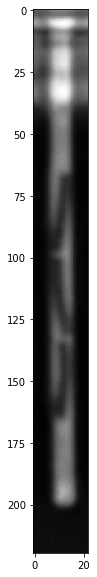

In [30]:
import h5py
from matplotlib import pyplot as plt

with h5py.File(headpath+"/kymograph/kymograph_25.hdf5") as infile:
    data = infile["Phase"][14]

plt.imshow(data[0],cmap="Greys_r")
plt.show()

## Fluorescence Segmentation

Now that you have copped your data into kymographs, we will now perform segmentation/cell detection <br>
on your kymographs. Currently, this pipeline only supports segmentation of fluorescence images; however, <br>
segmentation of transmitted light imaging techniques is in development.

The output of this step will be a set of `segmentation_[File #].hdf5` files stored in `headpath/fluorsegmentation`.<br>
The image data stored in these files takes the exact same form as the kymograph data, `(K,T,Y,X)` arrays <br>
where K is the trench index, T is time, and Y,X are the crop dimensions. These arrays are accessible using <br>
keys of the form `"[Trench Row Number]"`.

Since no metadata is generated by this step, it is possible to use another segmentation algorithm on the kymograph <br>
data. The output of segmentation must be split into `segmentation_[File #].hdf5` files, where `[File #]` agrees with the<br>
corresponding `kymograph_[File #].hdf5` file. Additionally, the `(K,T,Y,X)` arrays must be of the same shape as the <br>
kymograph arrays and accessible at the corresponding `"[Trench Row Number]"` key. These files must be placed into <br>
their own folder at `headpath/foldername`. This folder may then be used in later steps.

### Test Parameters

##### Initialize the interactive segmentation class

As a first step, initialize the `tr.fluo_segmentation_interactive` class that will be handling all steps of generating a segmentation. 

In [11]:
interactive_segmentation = tr.fluo_segmentation_interactive(headpath)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


##### Choose channel to segment on

In [12]:
interactive_segmentation.choose_seg_channel_inter()

interactive(children=(Dropdown(description='seg_channel', options=('Phase', 'GFP'), value='Phase'), Button(des…

#### Import data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**fov_idx (int)** :

**n_trenches (int)** :

**t_range (tuple)** :

**t_subsample_step (int)** :

In [13]:
interactive_segmentation.import_array_inter()

interactive(children=(IntText(value=12, description='Number of trenches:'), IntRangeSlider(value=(0, 70), desc…

##### Process data

In [14]:
interactive_segmentation.plot_processed_inter()

interactive(children=(IntSlider(value=1000, description='8-bit Maximum:', max=65535, step=250), Dropdown(descr…

#### Determine Cell Mask Envelope

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**cell_mask_method (str)** : Thresholding method, can be a local or global Otsu threshold.

**cell_otsu_scaling (float)** : Scaling factor applied to determined threshold.

**local_otsu_r (int)** : Radius of thresholding kernel used in the local otsu thresholding.

In [15]:
interactive_segmentation.plot_cell_mask_inter()

interactive(children=(IntSlider(value=50, description='Global Threshold:', max=255), FloatSlider(value=1.0, de…

In [16]:
interactive_segmentation.plot_eig_mask_inter()

interactive(children=(FloatSlider(value=1.0, description='Edge Threshold Scaling:', max=2.0, step=0.01), Butto…

In [17]:
interactive_segmentation.plot_dist_mask_inter()

interactive(children=(IntSlider(value=2, description='Distance Threshold:', max=20), Button(description='Run I…

In [18]:
interactive_segmentation.plot_marker_mask_inter()

interactive(children=(FloatSlider(value=1.0, description='Edge Threshold Scaling:', max=2.0, step=0.01), IntSl…

In [19]:
interactive_segmentation.process_results()

8 Bit Maximum: 2500
Scale Fluorescence? False
Scaling Percentile: 90
Image Scaling Factor: 1.0
Gaussian Kernel Sigma: 1.0
Global Threshold: 35
Cell Threshold Scaling: 1.0
Local Otsu Radius: 11
Minimum Object Size: 30
Niblack Scaling: 1.0
Distance Threshold: 2
Segmentation Channel: GFP


In [20]:
interactive_segmentation.write_param_file()

### Generate Segmentation

#### Start Dask Workers

In [21]:
dask_controller = tr.trcluster.dask_controller(
    walltime="01:00:00",
    local=False,
    n_workers=50,
    memory="1GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

In [22]:
dask_controller.displaydashboard()

In [24]:
segment = tr.segment.fluo_segmentation_cluster(headpath, paramfile=True)

In [25]:
segment.dask_segment(dask_controller)

#### Stop Dask Workers

In [ ]:
dask_controller.shutdown()

Future exception was never retrieved
future: <Future finished exception=CommClosedError("in <closed TCP>: Stream is closed: while trying to call remote method 'restart'")>
Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", line 188, in read
    n_frames = await stream.read_bytes(8)
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 686, in send_recv_from_rpc
    result = await send_recv(comm=comm, op=key, **kwargs)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/core.py", line 540, in send_recv
    response = await comm.read(deserializers=deserializers)
  File "/home/de64/miniconda3/envs/trenchripper/lib/python3.7/site-packages/distributed/comm/tcp.py", li

## Lineage Tracing

### Test Parameters

In [5]:
score_function = tr.tracking.scorefn(
    headpath,
    "fluorsegmentation",
    u_size=0.22,
    sig_size=0.08,
    u_pos=0.21,
    sig_pos=0.1,
    w_merge=0.8,
)

In [6]:
score_function.interactive_scorefn()

interactive(children=(IntSlider(value=0, description='trenchid', max=6566), IntRangeSlider(value=(0, 70), cont…

In [11]:
Tracking_Solver = tr.tracking.tracking_solver(
    headpath,
    "fluorsegmentation",
    ScoreFn=score_function,
    edge_limit=2,
)
data, orientation = score_function.output.result

In [12]:
Tracking_Solver.interactive_tracking(data, orientation)

interactive(children=(SelectMultiple(description='intensity_channel_list', options=('Phase', 'GFP'), value=())…

In [13]:
Tracking_Solver.save_params()

Channels: ['Phase', 'GFP']
Closest N Objects to Consider: 2
Mean Size Increase: 0.22
Standard Deviation of Size Increase: 0.08
Mean Position Increase: 0.21
Standard Deviation of Position Increase: 0.1
Cell Position Weight: 1.0
Cell Size Weight: 1.0
Cell Merging Weight: 0.8


### Generate Lineage Traces

In [3]:
dask_controller = tr.trcluster.dask_controller(
    walltime="01:00:00",
    local=False,
    n_workers=10,
    memory="2GB",
    working_directory=headpath + "/dask",
)
dask_controller.startdask()

In [4]:
dask_controller.displaydashboard()

In [5]:
Tracking_Solver = tr.tracking.tracking_solver(
    headpath, "fluorsegmentation", paramfile=True
)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [6]:
Tracking_Solver.compute_all_lineages(dask_controller)

/home/de64/miniconda3/envs/trenchripper/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [7]:
dask_controller.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


## Region Properties (No Lineage)

In [ ]:
analyzer = tr.analysis.regionprops_extractor(
    headpath, "fluorsegmentation", intensity_channel_list=["mCherry", "YFP"]
)

In [ ]:
analyzer.export_all_data()

## Inspect Kymographs

In [14]:
from ipywidgets import interactive, IntText, IntSlider

kyview = tr.analysis.kymograph_viewer(headpath, "Phase", "fluorsegmentation")

In [15]:
%matplotlib widget
kyviewer = interactive(
    kyview.inspect_trench,
    {"manual": True},
    file_idx=IntText(value=0, description="File Index:", disabled=False),
    trench_idx=IntText(value=0, description="Trench Index:", disabled=False),
    x_size=IntSlider(
        value=20, description="X Size:", min=0, max=50, step=1, disabled=False
    ),
    y_size=IntSlider(
        value=6, description="Y Size:", min=0, max=30, step=1, disabled=False
    ),
)
display(kyviewer)

interactive(children=(IntText(value=0, description='File Index:'), IntText(value=0, description='Trench Index:…

In [ ]:
interact(
    interactive_kymograph.view_image,
    fov_idx=IntText(value=0, description="FOV number:", disabled=False),
    t=IntSlider(
        value=0, min=0, max=timepoints_len - 1, step=1, continuous_update=False
    ),
    channel=Dropdown(
        options=channels, value=channels[0], description="Channel:", disabled=False
    ),
    invert=Dropdown(options=[True, False], value=False),
)

## Phase Segmentation Training

### Data Preparation

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest7",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    testpath="/n/scratch2/de64/2019-05-31_validation_data",
    valpath="/n/scratch2/de64/2019-05-31_validation_data",
)

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest8",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-05-31_validation_data",
    testpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    valpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
)

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest9",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-05-31_validation_data",
    testpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    valpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
)

In [ ]:
dataloader = tr.unet.UNet_Training_DataLoader(
    nndatapath="/n/scratch2/de64/nntest10",
    experimentname="First NN",
    trainpath="/n/scratch2/de64/2019-06-18_DE85_training_data",
    testpath="/n/scratch2/de64/2019-05-31_validation_data",
    valpath="/n/scratch2/de64/2019-05-31_validation_data",
)

#### Training Set Selection

In [ ]:
dataloader.inter_get_selection(dataloader.trainpath, "train")

#### Test Set Selection

In [ ]:
dataloader.inter_get_selection(dataloader.testpath, "test")

#### Validation Set Selection

In [ ]:
dataloader.inter_get_selection(dataloader.valpath, "val")

#### Weightmap Parameters

In [ ]:
dataloader.display_grid()

In [ ]:
dataloader.get_grid_params()

#### Export

In [ ]:
dataloader.export_all_data(memory="6GB")

### Hyperparameter (Grid) Search

#### Set-up Search

In [ ]:
grid = tr.unet.GridSearch("/n/scratch2/de64/nntest10", numepochs=15)

In [ ]:
grid.display_grid()

In [ ]:
grid.get_grid_params()

#### Run Search

In [ ]:
grid.run_grid_search(gres="gpu:teslaK80:1")

#### Evaluate Results

In [ ]:
%matplotlib ipympl
matplotlib.rcParams["figure.figsize"] = [12, 8]

import seaborn as sns

sns.set()
sns.set(font_scale=2)

In [ ]:
vis = tr.unet.TrainingVisualizer(
    "/n/scratch2/de64/nntest10", "/n/groups/paulsson/Daniel/NNModels"
)

In [ ]:
vis.inter_plot_loss("Val Loss")
vis.grid_widget.on("filter_changed", vis.handle_filter_changed)

In [ ]:
vis.grid_widget

In [ ]:
vis.inter_df_columns()

In [ ]:
vis.model_widget

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

plt.hist(vis.model_df["Val F1 Cell Scores"][0], bins=50)
plt.xlabel("F-Score")
plt.ylabel("Occurances")
plt.xticks(np.arange(0, 1.01, step=0.5))
plt.draw()

In [ ]:
headpath = "/n/scratch2/de64/2019-07-08_bacillus_rodz_mut_expt_bmbm_ti4"
unetseg = tr.unet.UNet_Segmenter(
    headpath, "Phase", "/n/groups/paulsson/Daniel/NNModels", min_obj_size=20
)

In [ ]:
choose_channel = interactive(
    unetseg.choose_seg_channel,
    {"manual": True},
    seg_channel=Dropdown(options=unetseg.all_channels, value=unetseg.all_channels[0]),
)
display(choose_channel)

In [ ]:
unetseg.inter_df_columns()

In [ ]:
import torch
import numpy as np
import h5py
import trenchripper as tr
from matplotlib import pyplot as plt

In [ ]:
with h5py.File("/n/scratch2/de64/nntest7/test.hdf5", "r") as infile:
    img_arr = torch.Tensor(infile["img"][535:550])
    seg_arr = torch.Tensor(infile["seg"][100:200:10])
    weight_arr = infile["weight_(10.0, 4.0)"][0:300:10]

In [ ]:
testunet = tr.unet.UNet(1, 2, layers=3, hidden_size=32, dropout=0.0, withsoftmax=True)
device = torch.device("cpu")
testunet.load_state_dict(
    torch.load("/n/scratch2/de64/nntest7/models/0.pt", map_location=device)
)

In [ ]:
y = testunet.forward(img_arr).detach().numpy()[:, 1]
x = img_arr.detach().numpy().squeeze(1)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[4])

In [ ]:
plt.imshow(y[4])

In [ ]:
img_kymo = tr.utils.kymo_handle()
img_kymo.import_wrap(x)
img = img_kymo.return_unwrap(padding=0)
plt.imshow(img)

In [ ]:
seg_kymo = tr.utils.kymo_handle()
seg_kymo.import_wrap(y)
seg = seg_kymo.return_unwrap(padding=0)
plt.imshow(seg)

In [ ]:
mask = seg > 0.6
plt.imshow(mask)

In [ ]:
import skimage as sk

In [ ]:
filtered_mask = sk.morphology.remove_small_objects(mask, min_size=30)

In [ ]:
plt.imshow(filtered_mask)

## Other

#### Transfer files into the scratch folder

If you are working on the HMS O2 server, this is a convenience function to facilitate transfer of files onto the `/n/scratch2` folder.

In [ ]:
sourcedir = "/n/files/SysBio/PAULSSON\ LAB/Personal\ Folders/Daniel/Image_Data/Bacillus_Project/2019-05-31_DE85_training_data/exp_folder"
targetdir = "/n/scratch2/de64/2019-05-31_validation_data"
tr.trcluster.transferjob(sourcedir, targetdir)

#### Dask Utilities

In [ ]:
dask_controller.shutdown()

In [ ]:
dask_controller.retry_failed()

In [ ]:
dask_controller.daskclient.restart()

In [ ]:
dask_controller.retry_processing()